# Key information
- Date : 30th December 2024
- Author : Gayatri Arani 


### Import modules 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Step 1: Simulate Data
We will generate data for 30 patients, measured weekly for 4 weeks. Patients will belong to one of three treatment groups: low-dose, high-dose, or placebo.

In [3]:
# Simulate data
np.random.seed(42)  # For reproducibility

# Number of patients and weeks
n_patients = 30
weeks = 4

In [6]:
# Create a dataset
data = []
for i in range(1, n_patients + 1):
    group = np.random.choice(['Placebo', 'LowDose', 'HighDose'])  # Random treatment group
    baseline = np.random.normal(120, 10)  # Baseline BP around 120
    slope = -np.random.uniform(0.5, 2.0) if group != 'Placebo' else np.random.uniform(-0.5, 0.5)  # Slope depends on treatment
    for week in range(1, weeks + 1):
        bp = baseline + slope * week + np.random.normal(0, 5)  # Add random noise
        data.append([i, week, bp, group])
        
        # Convert to DataFrame
df = pd.DataFrame(data, columns=['PatientID', 'Week', 'BloodPressure', 'Group'])

# Display the first few rows
print(df.head())

   PatientID  Week  BloodPressure    Group
0          1     1     102.784486  LowDose
1          1     2      98.049629  LowDose
2          1     3      99.922746  LowDose
3          1     4     100.405400  LowDose
4          2     1     122.171470  Placebo


### Step 2: Stage 1 Analysis (Within-Patient)
Fit a regression model for each patient to estimate their baseline (intercept) and slope of blood pressure over time.

In [7]:
# Dictionary to store results for each patient
patient_results = []
# Loop through each patient
for patient_id in df['PatientID'].unique():
    # Subset data for this patient
    patient_data = df[df['PatientID'] == patient_id]
    
  # Fit a linear regression model: BloodPressure ~ Week
    X = sm.add_constant(patient_data['Week'])  # Add intercept term
    y = patient_data['BloodPressure']
    model = sm.OLS(y, X).fit()
    
    # Extract the intercept (baseline) and slope (rate of change)
    intercept = model.params['const']
    slope = model.params['Week']
    
    # Append results
    group = patient_data['Group'].iloc[0]  # Get the treatment group
    patient_results.append({'PatientID': patient_id, 'Intercept': intercept, 'Slope': slope, 'Group': group})

    # Convert results to a DataFrame
stage1_results = pd.DataFrame(patient_results)
print(stage1_results.head())


   PatientID   Intercept     Slope     Group
0          1  101.606600 -0.526414   LowDose
1          2  121.096605  1.053214   Placebo
2          3  109.900119 -1.507396   LowDose
3          4  138.382114 -3.906553  HighDose
4          5  125.243907 -3.107329  HighDose


### Step 3: Stage 2 Analysis (Across-Patient)
Relate the intercepts and slopes (from Stage 1) to the treatment groups.

In [8]:
# Encode treatment groups as dummy variables
stage1_results['Group_LowDose'] = (stage1_results['Group'] == 'LowDose').astype(int)
stage1_results['Group_HighDose'] = (stage1_results['Group'] == 'HighDose').astype(int)
stage1_results['Group_Placebo'] = (stage1_results['Group'] == 'Placebo').astype(int)

# Fit a regression model for the Slope ~ TreatmentGroup
X = stage1_results[['Group_LowDose', 'Group_HighDose']]  # Use dummy variables as predictors
X = sm.add_constant(X)  # Add intercept term
y = stage1_results['Slope']  # Slope as the dependent variable
stage2_model = sm.OLS(y, X).fit()

# Display summary of Stage 2 model
print(stage2_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Slope   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.048
Date:                Tue, 31 Dec 2024   Prob (F-statistic):              0.149
Time:                        02:02:46   Log-Likelihood:                -55.478
No. Observations:                  30   AIC:                             117.0
Df Residuals:                      27   BIC:                             121.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.9452      0.573     -1.

### Step 4: Visualize Results
Plot the average slopes for each treatment group.

Explanation of Results
Stage 1 Output: Each patient gets their own baseline BP (intercept) and rate of BP change (slope) over time.

Stage 2 Output: The regression model tells us how treatment groups (e.g., LowDose, HighDose) are associated with the slope of BP change. For example:

A negative slope for LowDose indicates a decrease in BP over time in that group.
- Placebo may have a near-zero slope (no significant change).
- Visualization: The bar chart shows the average rate of BP change (slope) for each group, helping you compare treatment effects.

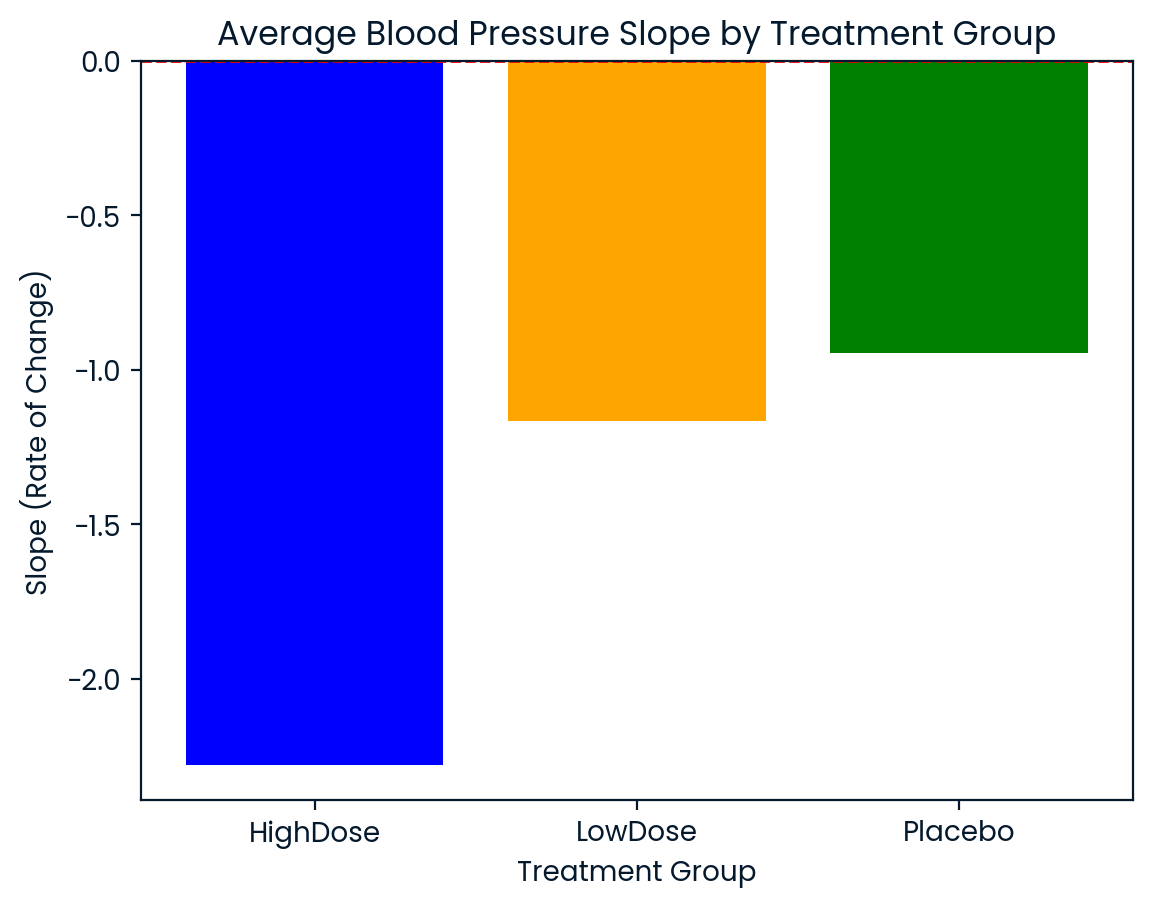

In [9]:
# Group results by treatment group to calculate mean slopes
group_means = stage1_results.groupby('Group')['Slope'].mean().reset_index()

# Plot
plt.bar(group_means['Group'], group_means['Slope'], color=['blue', 'orange', 'green'])
plt.title('Average Blood Pressure Slope by Treatment Group')
plt.ylabel('Slope (Rate of Change)')
plt.xlabel('Treatment Group')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Reference line for no change
plt.show()
